# Train DenseNet-169 model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
# os.environ['KERAS_BACKEND']='tensorflow'

# import tensorflow as tf
# tf.__version__

# ## Use tensorflow with CPU
# import tensorflow as tf
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)
# from keras import backend as K
# K.tensorflow_backend.set_session(session=sess)

In [4]:
import numpy as np

from data_utils import get_id_type_list_for_class, GENERATED_DATA, OUTPUT_PATH, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [5]:
from models.densenet_multiclassification import get_densenet

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import load_pretrained_model, get_label

In [7]:
from xy_providers import image_label_provider
from models.keras_metrics import binary_crossentropy_with_false_negatives

In [10]:
cnn = get_densenet(depth=169, input_shape=(224, 224, 3), n_classes=17, weights=None)
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_84 (ZeroPadding2D (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9408        zero_padding2d_84[0][0]          
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

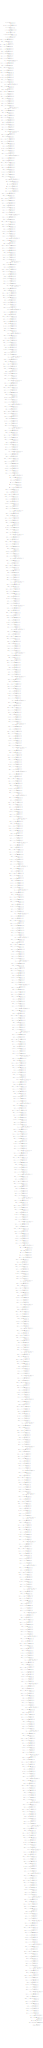

In [11]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

## Train on all classes

In [8]:
seed = 2017
np.random.seed(seed)

In [9]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]

print(len(trainval_id_type_list))

40479


In [10]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(10000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(10000)

In [ ]:
params = {
    'seed': seed,
    
    'xy_provider': image_label_provider,
    
    'network': get_densenet,
    'network_kwargs': {
        'depth': 169, 
        'input_shape': (224, 224, 3), 
        'n_classes': len(unique_tags),
        'weights': None
    },
    'image_size': (224, 224),
    
    'optimizer': 'adadelta',
    'loss': binary_crossentropy_with_false_negatives,
    'nb_epochs': 50,
    'batch_size': 8,    
    
    'normalize_data': True,
    'normalization': 'vgg',
        
    'lr_kwargs': {
        'lr': 0.1,
        'a': 0.95
        ,
        'init_epoch': 0
    },
    'lr_decay_f': exp_decay,
    
    # Reduce learning rate on plateau
    'on_plateau': True,
    'on_plateau_kwargs': {
        'monitor': 'val_loss',
        'factor': 0.1,
        'patience': 5,
        'verbose': 1
    },
    
    'cache': cache,
    
    'class_index': 0,
            
    'output_path': OUTPUT_PATH,

}

params['save_prefix_template'] = '{cnn_name}_all_classes_fold={fold_index}_seed=%i' % params['seed']

Start CV

In [ ]:
n_folds = 5
val_fold_index = 0
val_fold_indices = []
hists = []

kf = KFold(n_splits=n_folds)
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue

    val_fold_index += 1
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    
    cnn = params['network'](lr=params['lr_kwargs']['lr'], **params, **params['network_kwargs'])
    params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index - 1)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))

    if 'pretrained_model' in params:
        load_pretrained_model(cnn, **params)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  1 / 5
2017-07-11 08:24:03.444555 32383 8096


In [14]:
# output_path = params['output_path'] if 'output_path' in params else OUTPUT_PATH
# weights_path = os.path.join(output_path, "weights")
# weights_filename = os.path.join(weights_path, params['save_prefix'] + "_31_val_loss=6.9420.h5")

# cnn.save_weights(weights_filename)

### Validation all classes

In [24]:
n_runs = 1
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = []

In [ ]:
params['pretrained_model'] = 'load_best'

In [25]:
while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
    trainval_id_type_list = np.array(trainval_id_type_list)
    for train_index, test_index in kf.split(trainval_id_type_list):        
        train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue

        val_fold_index += 1        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        score = validate(cnn, val_id_type_list, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = score
    
print(cv_mean_scores)



 ---- New run :  1 / 1


 ---- Validation fold index:  1 / 5
102 26

 2017-07-05 01:38:54.812063 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_04_val_loss=9.4452_val_precision=0.2647_val_recall=0.6062.h5 9.4452
Total score :  0.265911961042


 ---- Validation fold index:  2 / 5
102 26

 2017-07-05 01:39:00.863901 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=1_seed=2017_03_val_loss=10.2769_val_precision=0.1780_val_recall=0.5460.h5 10.2769
Total score :  0.221133889793


 ---- Validation fold index:  3 / 5
102 26

 2017-07-05 01:39:07.236214 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=2_seed=2017_04_val_loss=7.9261_val_precision=0.2197_val_reca

In [26]:
np.mean(cv_mean_scores)

0.27650793599879664

### Visual validation

In [27]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile

import matplotlib.pylab as plt
%matplotlib inline

In [28]:
cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])

weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
assert len(weights_files) > 0, "Failed to load weights"
best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
print("Load best loss weights: ", best_weights_filename, best_val_loss)
cnn.load_weights(best_weights_filename)

Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=4_seed=2017_04_val_loss=10.1137_val_precision=0.1824_val_recall=0.5374.h5 10.1137


In [29]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=train_id_type_list, 
                                     imgaug_seq=imgaug_seq, 
                                     test_mode=True, **params)
channels_first = False


-- ('10096', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
y_pred:  [  9.82220411e-01   8.66256841e-03   8.82406116e-01   5.97537875e-01
   9.64096546e-01   3.19178790e-01   8.39661777e-01   1.67957321e-02
   5.74371636e-01   8.48137774e-04   1.54335517e-02   9.90148604e-01
   1.95307121e-01   3.51302445e-01   1.06034726e-01   2.59191904e-04
   2.30059698e-01]

-- ('10051', 'Train_jpg')
y_true:  [0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0]
y_pred:  [  3.85848820e-01   4.52345528e-04   9.99804616e-01   1.31079182e-01
   9.99844074e-01   1.45636108e-02   8.01513672e-01   9.74415302e-01
   5.14113717e-03   4.19348944e-04   3.00903339e-04   9.01373982e-01
   9.83469486e-01   2.70573318e-01   9.09561753e-01   7.01543391e-02
   7.33665675e-02]

-- ('10024', 'Train_jpg')
y_true:  [0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0]
y_pred:  [  9.71098602e-01   7.11524335e-04   9.99804497e-01   1.10830809e-03
   5.75430155e-01   3.73857409e-01   9.99454081e-01   5.02626412e-02
   4.53384966e-01   2.6219131

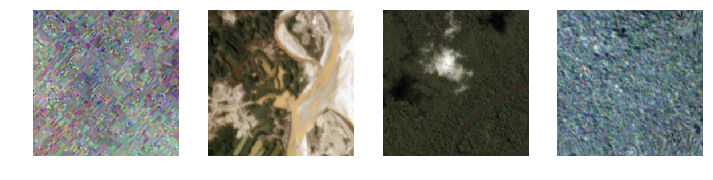

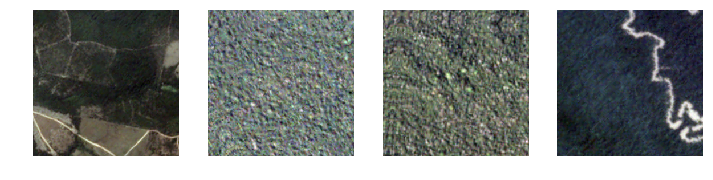

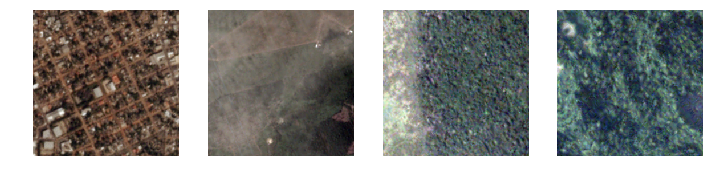

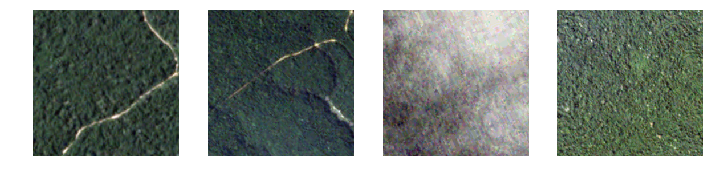

In [30]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict_on_batch(x)
    n = 4
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', y_pred[counter, :])        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

## Predict tags on test data

In [31]:
from data_utils import test_jpg_ids, test_jpg_files
from test_utils import classification_predict as predict

In [32]:
test_id_type_list = []
for image_id in test_jpg_ids:
    test_id_type_list.append((image_id, "Test_jpg"))

print(len(test_id_type_list))

40669


In [33]:
n_folds = 5
predictions = []
run_counter = 0
n_runs = 2

In [34]:
while run_counter < n_runs:
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)

    # SqueezeNet on 5 folds
    for val_fold_index in range(n_folds):
                
        val_fold_index += 1
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        
        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(OUTPUT_PATH, "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)
        
        params['seed'] += run_counter
        df = predict(cnn, test_id_type_list, **params)
        predictions.append(df)
 



 ---- New run :  1 / 2


 ---- Validation fold index:  1 / 5

 2017-07-05 01:42:16.912956 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_04_val_loss=9.4452_val_precision=0.2647_val_recall=0.6062.h5 9.4452
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  2 / 5

 2017-07-05 01:42:25.161256 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=1_seed=2017_03_val_loss=10.2769_val_precision=0.1780_val_recall=0.5460.h5 10.2769
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  3 / 5

 2017-07-05 01:42:32.715950 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=2_seed=2017_04_val_loss=7.9261_val_precision=0.2197_val

In [35]:
import pandas as pd

def compute_mean(predictions):
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

In [39]:
df = compute_mean(predictions)

# info = 'mean_cv=6_squeezenet'
# now = datetime.now()
# sub_file = 'submission_' + info + '.csv'
# sub_file = os.path.join('results', sub_file)
# df.to_csv(sub_file, index=False)

In [37]:
predictions[0].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.506258,0.562097,0.975057,0.001368,0.049075,0.002451,0.961137,0.661215,0.000105,0.000004,0.990789,0.010330,0.047737,0.033023,0.900089,0.055774,0.597479
1,10013.jpg,0.112824,0.992581,0.665956,0.022905,0.252470,0.002009,0.758580,0.047629,0.030355,0.000051,0.956831,0.045855,0.181108,0.420796,0.425628,0.548716,0.586713
2,10026.jpg,0.683666,0.770768,0.754240,0.005178,0.920248,0.004585,0.557355,0.951823,0.004545,0.000106,0.952081,0.383490,0.100664,0.102589,0.763708,0.336883,0.314157
3,10051.jpg,0.558847,0.923822,0.997724,0.000904,0.736889,0.000934,0.987514,0.774715,0.053452,0.000031,0.848869,0.003037,0.161278,0.065336,0.836500,0.738170,0.758234
4,10050.jpg,0.001674,0.981961,0.694869,0.227738,0.220498,0.000028,0.957476,0.531832,0.078176,0.000003,0.985369,0.361313,0.019534,0.050918,0.999852,0.002664,0.004680


In [38]:
predictions[1].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.465652,0.030405,0.269544,0.409754,0.857248,0.025975,0.999920,0.051838,0.066960,0.978959,0.883892,0.873516,0.995550,0.026185,0.462543,0.000612,0.000681
1,10039.jpg,0.093729,0.006439,0.759044,0.983510,0.221559,0.087380,0.889295,0.521726,0.998706,0.915714,0.597018,0.769996,0.985642,0.762664,0.908943,0.003693,0.121895
2,10036.jpg,0.561332,0.621638,0.481471,0.177879,0.391414,0.203498,0.980438,0.157688,0.990710,0.993740,0.612709,0.829291,0.997904,0.583979,0.812165,0.000005,0.095353
3,10026.jpg,0.062532,0.030563,0.024138,0.176282,0.614454,0.046622,0.992656,0.032808,0.879304,0.937467,0.414737,0.823702,0.973572,0.532634,0.751906,0.001167,0.028366
4,10011.jpg,0.099131,0.705599,0.583571,0.962048,0.500123,0.025582,0.957145,0.117518,0.997569,0.984932,0.130966,0.229523,0.986412,0.920123,0.739398,0.005017,0.341393


In [40]:
df.head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,0.jpg,0.547587,0.394494,0.748083,0.417404,0.759704,0.189018,0.661740,0.350495,0.622014,0.384360,0.663181,0.509230,0.511590,0.385018,0.720199,0.288789,0.478163
1,1.jpg,0.418558,0.205205,0.738539,0.296904,0.546367,0.327220,0.582137,0.311244,0.478286,0.582767,0.810059,0.641347,0.475419,0.401459,0.787750,0.096000,0.614872
2,10.jpg,0.519530,0.400793,0.584262,0.434872,0.489117,0.170434,0.582213,0.592595,0.593682,0.410522,0.551644,0.484007,0.575560,0.538420,0.883766,0.204803,0.673564
3,100.jpg,0.289584,0.456127,0.891757,0.353185,0.745096,0.119059,0.717935,0.476995,0.553315,0.433153,0.844619,0.636376,0.686859,0.390396,0.892342,0.350472,0.409009
4,1000.jpg,0.481877,0.281683,0.754391,0.282936,0.650377,0.148259,0.534274,0.453858,0.638972,0.476578,0.444342,0.567461,0.597796,0.410205,0.700519,0.346194,0.288687
